In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# cwd = os.getcwd()
# cwd

In [3]:
# raw_csv_data = pd.read_csv(cwd + '\TG.csv')
raw_csv_data = pd.read_csv('WB.csv')
df=raw_csv_data.copy()

In [4]:
para = 'Confirmed'

In [5]:
df.Date.describe()

count           115
unique          115
top       17-May-20
freq              1
Name: Date, dtype: object

In [6]:
df

,Date,Confirmed,Recovered,Decreased
0,14-Mar-20,0,0,0
1,15-Mar-20,0,0,0
2,16-Mar-20,0,0,0
3,17-Mar-20,1,0,0
4,18-Mar-20,0,0,0
...,...,...,...,...
110,02-Jul-20,649,509,16
111,03-Jul-20,669,534,18
112,04-Jul-20,743,595,19
113,05-Jul-20,895,545,21


In [7]:
df.Date = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,0,0,0
1,2020-03-15,0,0,0
2,2020-03-16,0,0,0
3,2020-03-17,1,0,0
4,2020-03-18,0,0,0


In [9]:
df

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,0,0,0
1,2020-03-15,0,0,0
2,2020-03-16,0,0,0
3,2020-03-17,1,0,0
4,2020-03-18,0,0,0
...,...,...,...,...
110,2020-07-02,649,509,16
111,2020-07-03,669,534,18
112,2020-07-04,743,595,19
113,2020-07-05,895,545,21


In [10]:
df.set_index('Date', inplace=True)
df.index.freq = 'D'

In [11]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,0,0,0
2020-03-15,0,0,0
2020-03-16,0,0,0
2020-03-17,1,0,0
2020-03-18,0,0,0
...,...,...,...
2020-07-02,649,509,16
2020-07-03,669,534,18
2020-07-04,743,595,19


In [12]:
# df.Date.describe()

In [13]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,0,0,0
2020-03-15,0,0,0
2020-03-16,0,0,0
2020-03-17,1,0,0
2020-03-18,0,0,0
...,...,...,...
2020-07-02,649,509,16
2020-07-03,669,534,18
2020-07-04,743,595,19


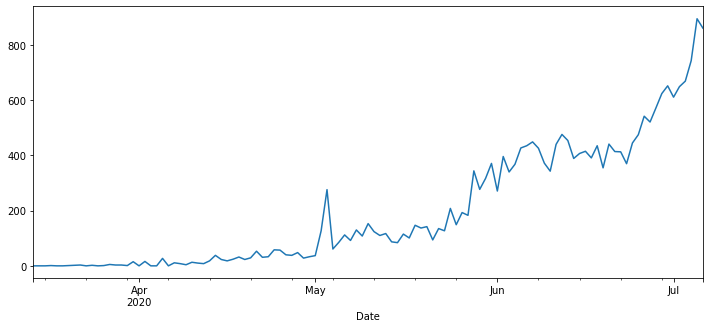

In [14]:
df[para].plot(figsize=(12,5));

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(df[para])

Augmented Dickey-Fuller Test: 
ADF test statistic        3.012013
p-value                   1.000000
# lags used               4.000000
# observations          110.000000
critical value (1%)      -3.491245
critical value (5%)      -2.888195
critical value (10%)     -2.580988
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


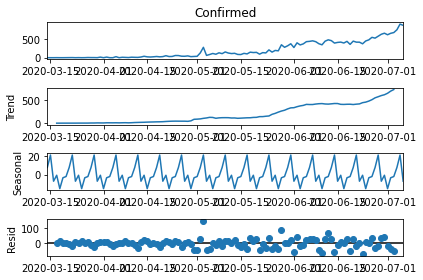

In [17]:
result = seasonal_decompose(df[para])
result.plot();

In [18]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df[para],k_diff=2)

In [19]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.131971e+00
p-value                 3.498787e-10
# lags used             8.000000e+00
# observations          1.040000e+02
critical value (1%)    -3.494850e+00
critical value (5%)    -2.889758e+00
critical value (10%)   -2.581822e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [20]:
# stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
#                           max_p=4, max_q=4,
#                           seasonal=False,
#                           d=None, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
                          max_p=4, max_q=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,           # set to stepwise
                         frequency=15)

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1311.216, BIC=1316.671, Time=0.011 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1252.043, BIC=1260.225, Time=0.041 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1204.251, BIC=1212.433, Time=0.128 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1309.218, BIC=1311.945, Time=0.011 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1232.268, BIC=1243.178, Time=0.071 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=1224.757, BIC=1238.394, Time=0.105 seconds
Fit ARIMA(4,2,0)x(0,0,0,0) [intercept=True]; AIC=1209.290, BIC=1225.654, Time=0.113 seconds
Fit ARIMA(4,2,1)x(0,0,0,0) [intercept=True]; AIC=1190.333, BIC=1209.425, Time=0.327 seconds
Near non-invertible roots for order (4, 2, 1)(0, 0, 0, 0); set

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(4, 2, 1)   Log Likelihood                -588.167
Date:                Wed, 15 Jul 2020   AIC                           1190.333
Time:                        23:56:43   BIC                           1209.425
Sample:                             0   HQIC                          1198.080
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4183      0.203      2.060      0.039       0.020       0.816
ar.L1         -0.4493      0.068     -6.579      0.000      -0.583      -0.315
ar.L2         -0.2148      0.110     -1.952      0.051      -0.430       0.001
ar.L3         -0.1979      0.120     -1.652      0.099      -0.433       0.037
ar.L4         -0.1548      0.110     -1.409      0.159      -0.370       0.061
ma.L1         -0.9996      2.130     -0.469      0.639      -5.175       3.176
sigma2      1836.8497   3846.556      0.478      0.633   -5702.262    9375.961
===================================================================================
Ljung-Box (Q):                       43.11   Jarque-Bera (JB):               106.65
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):              30.34   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
train = df.iloc[:104]
test = df.iloc[104:111]

In [22]:
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# model = ARIMA(train[para],order=(4, 2, 1))
model = SARIMAX(train[para],order=(4, 2, 1),seasonal_order=(4,2,1,15))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Confirmed   No. Observations:                  104
Model:             SARIMAX(4, 2, 1)x(4, 2, 1, 15)   Log Likelihood                -412.431
Date:                            Wed, 15 Jul 2020   AIC                            846.863
Time:                                    23:57:04   BIC                            871.906
Sample:                                03-14-2020   HQIC                           856.832
                                     - 06-25-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5212      0.117     -4.442      0.000      -0.751      -0.291
ar.L2         -0.1943      0.162     -1.200      0.230      -0.512       0.123
ar.L3         -0.1974      0.201     -0.983      0.326      -0.591       0.196
ar.L4         -0.1443      0.177     -0.814      0.416      -0.492       0.203
ma.L1         -0.9971      1.817     -0.549      0.583      -4.558       2.564
ar.S.L15      -1.1036     21.648     -0.051      0.959     -43.534      41.327
ar.S.L30      -0.9286     25.053     -0.037      0.970     -50.032      48.175
ar.S.L45      -0.7448     18.520     -0.040      0.968     -37.043      35.553
ar.S.L60      -0.3163     10.114     -0.031      0.975     -20.138      19.506
ma.S.L15      -0.3090     28.049     -0.011      0.991     -55.283      54.665
sigma2      2928.7155   1.12e+04      0.263      0.793   -1.89e+04    2.48e+04
===================================================================================
Ljung-Box (Q):                       46.56   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.22   Prob(JB):                         0.89
Heteroskedasticity (H):               2.68   Skew:                             0.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
# start=len(train)
# end=len(train)+len(test)-1

start=104
end=110

# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(4,2,1,15) Predictions')

# df['forecast'] = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')

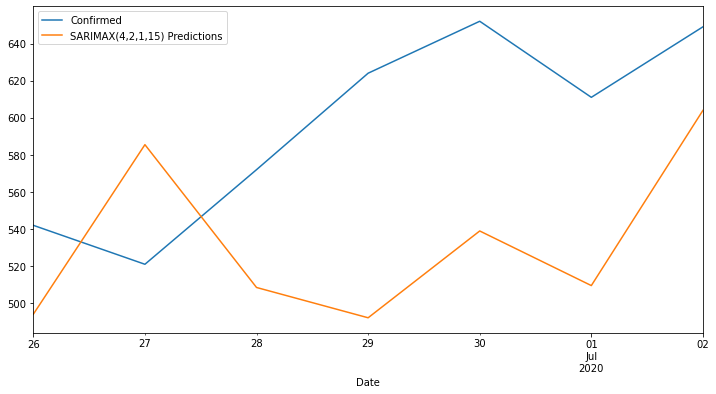

In [25]:
# Obtain predicted values
ax = test[para].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
# df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [26]:
# # from statsmodels.tools.eval_measures import rmse
# from statsmodels.tools.eval_measures import mse

# error = mse(test[para], predictions)
# # print(f'ARIMA(2,2,1) RMSE Error: {error:11.10}')
# # print(f'ARIMA(2,2,1) MSE Error: {error:11.10}')
# print(f'SARIMAX(2,2,1,3) MSE Error: {error:11.10}')

In [27]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test[para], predictions)
MAE

81.04569713112723

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# per_MAPE = (MAPE/sum(test[para]))*100
per_MAPE = mean_absolute_percentage_error(test[para], predictions)
print(per_MAPE,'%')

13.476649781119113 %


In [29]:
type(predictions)

pandas.core.series.Series

In [30]:
df['forecast'] = predictions
df

,Confirmed,Recovered,Decreased,d1,forecast
Date,,,,,
2020-03-14,0,0,0,NaN,NaN
2020-03-15,0,0,0,NaN,NaN
2020-03-16,0,0,0,0.0,NaN
2020-03-17,1,0,0,1.0,NaN
2020-03-18,0,0,0,-2.0,NaN
...,...,...,...,...,...
2020-07-02,649,509,16,79.0,603.956236
2020-07-03,669,534,18,-18.0,NaN
2020-07-04,743,595,19,54.0,NaN


In [31]:
dictt = {f'{para}':test[para],f'Predicted_{para}':predictions}
dictt

{'Confirmed': Date
 2020-06-26    542
 2020-06-27    521
 2020-06-28    572
 2020-06-29    624
 2020-06-30    652
 2020-07-01    611
 2020-07-02    649
 Freq: D, Name: Confirmed, dtype: int64,
 'Predicted_Confirmed': 2020-06-26    494.077396
 2020-06-27    585.479176
 2020-06-28    508.494449
 2020-06-29    492.160432
 2020-06-30    538.953772
 2020-07-01    509.517011
 2020-07-02    603.956236
 Freq: D, Name: SARIMAX(4,2,1,15) Predictions, dtype: float64}

In [32]:
predicted_df = pd.DataFrame(dictt)
predicted_df

,Confirmed,Predicted_Confirmed
Date,,
2020-06-26,542,494.077396
2020-06-27,521,585.479176
2020-06-28,572,508.494449
2020-06-29,624,492.160432
2020-06-30,652,538.953772
2020-07-01,611,509.517011
2020-07-02,649,603.956236


In [33]:
predicted_df.to_csv('Predicted_WB.csv')
# predicted_csv = pd.read_csv('Predicted_WB.csv')

# predicted_csv.Date = pd.to_datetime(predicted_csv.Date)
# predicted_csv.set_index('Date', inplace=True)
# predicted_csv.index.freq = 'D'
# # print(predicted_csv)
# # predicted_csv = pd.concat([predicted_csv,predicted_df],axis=1,ignore_index=True)
# predicted_csv = pd.merge(predicted_csv, predicted_df, left_index=True, right_index=True, how='outer')
# # predicted_csv = predicted_csv.join(predicted_df, how='outer')
# print(predicted_csv)
# predicted_csv.to_csv('Predicted_WB.csv')

In [34]:
from pandas.tseries.offsets import DateOffset
import datetime
future_dates=[datetime.datetime(2020, 7, 7)+ DateOffset(n=x)for x in range(0,25)]

In [35]:
future_datest_df=pd.DataFrame(index=future_dates,columns=df.columns)

In [36]:
future_datest_df.tail()

,Confirmed,Recovered,Decreased,d1,forecast
2020-07-27,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN


In [37]:
future_df=pd.concat([df,future_datest_df])
future_df = future_df.drop("d1", axis=1)
future_df

,Confirmed,Recovered,Decreased,forecast
2020-03-14,0,0,0,NaN
2020-03-15,0,0,0,NaN
2020-03-16,0,0,0,NaN
2020-03-17,1,0,0,NaN
2020-03-18,0,0,0,NaN
...,...,...,...,...
2020-07-27,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN


In [38]:
future_df[[para, 'forecast']]

,Confirmed,forecast
2020-03-14,0,NaN
2020-03-15,0,NaN
2020-03-16,0,NaN
2020-03-17,1,NaN
2020-03-18,0,NaN
...,...,...
2020-07-27,NaN,NaN
2020-07-28,NaN,NaN
2020-07-29,NaN,NaN
2020-07-30,NaN,NaN


In [39]:
# future_df['forecast'] = results.predict(start = 115, end = 139, dynamic= True)
future_pred = results.predict(start=115, end=139, dynamic=False, typ='levels')

In [40]:
future_df['forecast'] = future_pred

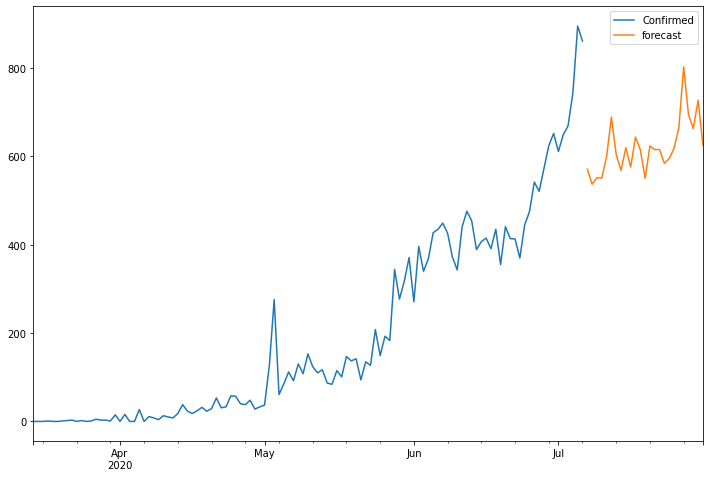

In [41]:
future_df[[para, 'forecast']].plot(figsize=(12, 8))

In [42]:
dicttt = {f'Future_Predicted_{para}':future_pred}
dicttt

{'Future_Predicted_Confirmed': 2020-07-07    570.970527
 2020-07-08    537.144913
 2020-07-09    551.713719
 2020-07-10    550.737129
 2020-07-11    599.214309
 2020-07-12    689.027049
 2020-07-13    603.845634
 2020-07-14    568.088346
 2020-07-15    619.701840
 2020-07-16    575.800544
 2020-07-17    643.706566
 2020-07-18    615.281961
 2020-07-19    550.324288
 2020-07-20    623.563097
 2020-07-21    615.427035
 2020-07-22    615.503478
 2020-07-23    584.096362
 2020-07-24    595.060670
 2020-07-25    618.352054
 2020-07-26    664.367202
 2020-07-27    802.767956
 2020-07-28    694.719500
 2020-07-29    662.748956
 2020-07-30    727.337756
 2020-07-31    625.139517
 Freq: D, dtype: float64}

In [43]:
future_predicted_df = pd.DataFrame(dicttt)
future_predicted_df

,Future_Predicted_Confirmed
2020-07-07,570.970527
2020-07-08,537.144913
2020-07-09,551.713719
2020-07-10,550.737129
2020-07-11,599.214309
2020-07-12,689.027049
2020-07-13,603.845634
2020-07-14,568.088346
2020-07-15,619.701840
2020-07-16,575.800544


In [44]:
future_predicted_df.index.names = ['Date']
future_predicted_df.index.freq = 'D'
future_predicted_df.to_csv('Future_Predicted_WB.csv')

# future_predicted_csv = pd.read_csv('Future_Predicted_WB.csv')

# future_predicted_csv.Date = pd.to_datetime(future_predicted_csv.Date)
# future_predicted_csv.set_index('Date', inplace=True)
# future_predicted_csv.index.freq = 'D'
# # print(future_predicted_csv)
# # future_predicted_csv = pd.concat([future_predicted_csv,future_predicted_df],axis=1,ignore_index=True)
# future_predicted_csv = pd.merge(future_predicted_csv, future_predicted_df, left_index=True, right_index=True, how='outer')
# # predicted_csv = predicted_csv.join(predicted_df, how='outer')
# print(future_predicted_csv)
# future_predicted_csv.to_csv('Future_Predicted_WB.csv')